In [1]:
import json
import numpy as np
import os.path
from os.path import exists
import pandas as pd
from scipy.stats import gaussian_kde
from corner import corner

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from inspect_results_helper_functions import * 

root = '../../..'
style.use(root+'/Figures/plotting.mplstyle')

import sys
sys.path.append(root+'/Figures')
from fig_helper_functions import calculate_chiEff, calculate_chiP

### Read in job lists

In [2]:
num_injections = 400
joblists_all = {}
joblists_inspected = {}

pop_names = ['population1_highSpinPrecessing', 'population2_mediumSpin', 'population3_lowSpinAligned']

for pop in pop_names:
    
    # load all jobs
    f = f'{root}/Code/IndividualInference/injlist_{pop}_' + str(num_injections) + 'events.txt'
    jobs = np.loadtxt(f)
    
    job_list = [int(job) for job in np.sort(jobs)]
    
    joblists_all[pop] = job_list
    
    # look for jobs already inspected
    f2 = f'{pop}_jobs_checked.txt'
    if exists(f2):
        job_list_inspected = np.loadtxt(f2)
        try:
            print(len(job_list_inspected))
            joblists_inspected[pop] = job_list_inspected
        except: 
            joblists_inspected[pop] = [job_list_inspected]
    else: 
        joblists_inspected[pop] = []

343
352
338


### Determine which jobs are done versus which aren't

In [3]:
joblists_finished = {}
joblists_missing = {}

for pop in pop_names: 
    
    print(pop)
    
    # Figure out which jobs we still need to look at
    jobs_all = joblists_all[pop]
    jobs_inspected = joblists_inspected[pop]
    jobs_remaining = [j for j in jobs_all if j not in jobs_inspected]
    
    # Look through them
    jobs_missing, job_list_finished = find_all_missing(pop, jobs_remaining)
    joblists_finished[pop] = np.concatenate((jobs_inspected, job_list_finished))
    joblists_missing[pop] = jobs_missing
    
    # Print how many 
    print(f'{len(joblists_finished[pop])} finished, {len(job_list_finished)} to plot')
    print('missing jobs: ', jobs_missing)
    print()

population1_highSpinPrecessing
343 finished, 0 to plot
missing jobs:  [171, 190, 397, 407, 474, 519, 554, 725, 875, 1236, 1379, 1533, 1559, 1689, 1799, 2217, 2248, 2638, 2672, 2675, 2918, 2999, 3126, 3597, 4074, 4324, 4452, 4599, 4849, 4913, 5331, 5694, 5746, 5749, 5762, 5877, 6087, 6203, 6253, 6605, 6863, 6977, 7063, 7167, 7239, 7504, 7641, 7753, 8363, 8591, 8965, 9062, 9210, 9431, 9473, 9577, 9925]

population2_mediumSpin
352 finished, 0 to plot
missing jobs:  [19, 45, 347, 662, 804, 845, 1055, 1081, 1217, 1280, 1474, 1651, 2134, 2460, 2567, 3300, 3396, 3668, 3833, 4054, 4263, 4301, 4550, 4713, 5028, 5361, 5382, 5600, 5884, 6237, 6483, 6505, 6883, 6887, 7670, 8096, 8119, 8600, 8630, 8787, 8986, 9232, 9249, 9416, 9429, 9673, 9933, 9986]

population3_lowSpinAligned
338 finished, 0 to plot
missing jobs:  [89, 367, 490, 945, 1419, 1465, 1862, 2011, 2041, 2398, 2413, 2456, 2602, 2686, 2761, 2950, 3141, 3172, 3568, 3760, 3945, 4034, 4223, 4338, 4468, 4614, 4684, 5142, 5539, 5662, 5686, 583

### Plot histogram of parameters for events that have finished

In [4]:
f_root = '../../InjectedPopulationParameters/'
pop1 = pd.read_json(f_root+'population1_highSpinPrecessing_fullmassrange.json')
pop2 = pd.read_json(f_root+'population2_mediumSpin_fullmassrange.json')
pop3 = pd.read_json(f_root+'population3_lowSpinAligned_fullmassrange.json')

In [5]:
def calculate_params_dict(joblist, pops=[pop1, pop2, pop3]):
    
    params_dict = {}

    for i,pop in enumerate(pops):

        chis = []
        costs = []
        chieffs = []
        chips = []
        m1s = []
        m2s = []
        qs = []
        zs = []

        for job in joblist[pop_names[i]]:

            JOB_ID = int(job)

            # masses 
            m1 = pop.m1[JOB_ID]
            m2 = pop.m2[JOB_ID]
            m1s += [m1]
            m2s += [m2]

            # redshift
            zs += [pop.z[JOB_ID]]

            # spin magnitude
            chi1 = np.sqrt(pop.s1x[JOB_ID]**2 + pop.s1y[JOB_ID]**2 + pop.s1z[JOB_ID]**2)
            chi2 = np.sqrt(pop.s2x[JOB_ID]**2 + pop.s2y[JOB_ID]**2 + pop.s2z[JOB_ID]**2)
            chis += [chi1]
            chis += [chi2]

            # tilt angle
            cost1 = pop.s1z[JOB_ID]/chi1
            cost2 = pop.s2z[JOB_ID]/chi2
            costs += [cost1]
            costs += [cost2]

            # chi effective
            q = m2/m1
            qs += [q]
            chieff = calculate_chiEff(chi1, chi2, cost1, cost2, q)
            chieffs += [chieff]

            # chi p
            sint1 = np.sin(np.arccos(cost1))
            sint2 = np.sin(np.arccos(cost2))
            chip = calculate_chiP(chi1, chi2, sint1, sint2, q)
            chips += [chip]

        params_dict[pop_names[i]] = {
            'chi':chis, 
            'cost':costs, 
            'chieff':chieffs, 
            'chip':chips, 
            'm1':m1s,
            'm2':m2s,
            'q':qs,
            'z':zs
        }
        
    return params_dict

In [6]:
# Finished vs. not finished job lists
params_dict_finished = calculate_params_dict(joblists_finished)
params_dict_missing = calculate_params_dict(joblists_missing)

In [7]:
# Set up grids to evaluate KDEs on
m1_grid = np.linspace(6,85,500)
m2_grid =  np.linspace(6,85,500)
q_grid =  np.linspace(0,1,500)
z_grid =  np.linspace(0,1.5,500)

# make and evaluate kdes
m1_kde = reflective_kde_on_grid(np.concatenate((np.asarray(pop1.m1), np.asarray(pop2.m1), np.asarray(pop3.m1))), m1_grid)
m2_kde = reflective_kde_on_grid(np.concatenate((np.asarray(pop1.m2), np.asarray(pop2.m2), np.asarray(pop3.m2))), m2_grid)

q = np.concatenate((np.asarray(pop1.m2/pop1.m1),  np.asarray(pop2.m2/pop2.m1),  np.asarray(pop3.m2/pop3.m1)))
q_kde = reflective_kde_on_grid(q, q_grid)

z_kde =reflective_kde_on_grid(np.concatenate((np.asarray(pop1.z), np.asarray(pop2.z), np.asarray(pop3.z))), z_grid)

# put KDEs into dict
kde_dict = {
    'm1':m1_kde, 
    'm2':m2_kde, 
    'q':q_kde, 
    'z':z_kde
}

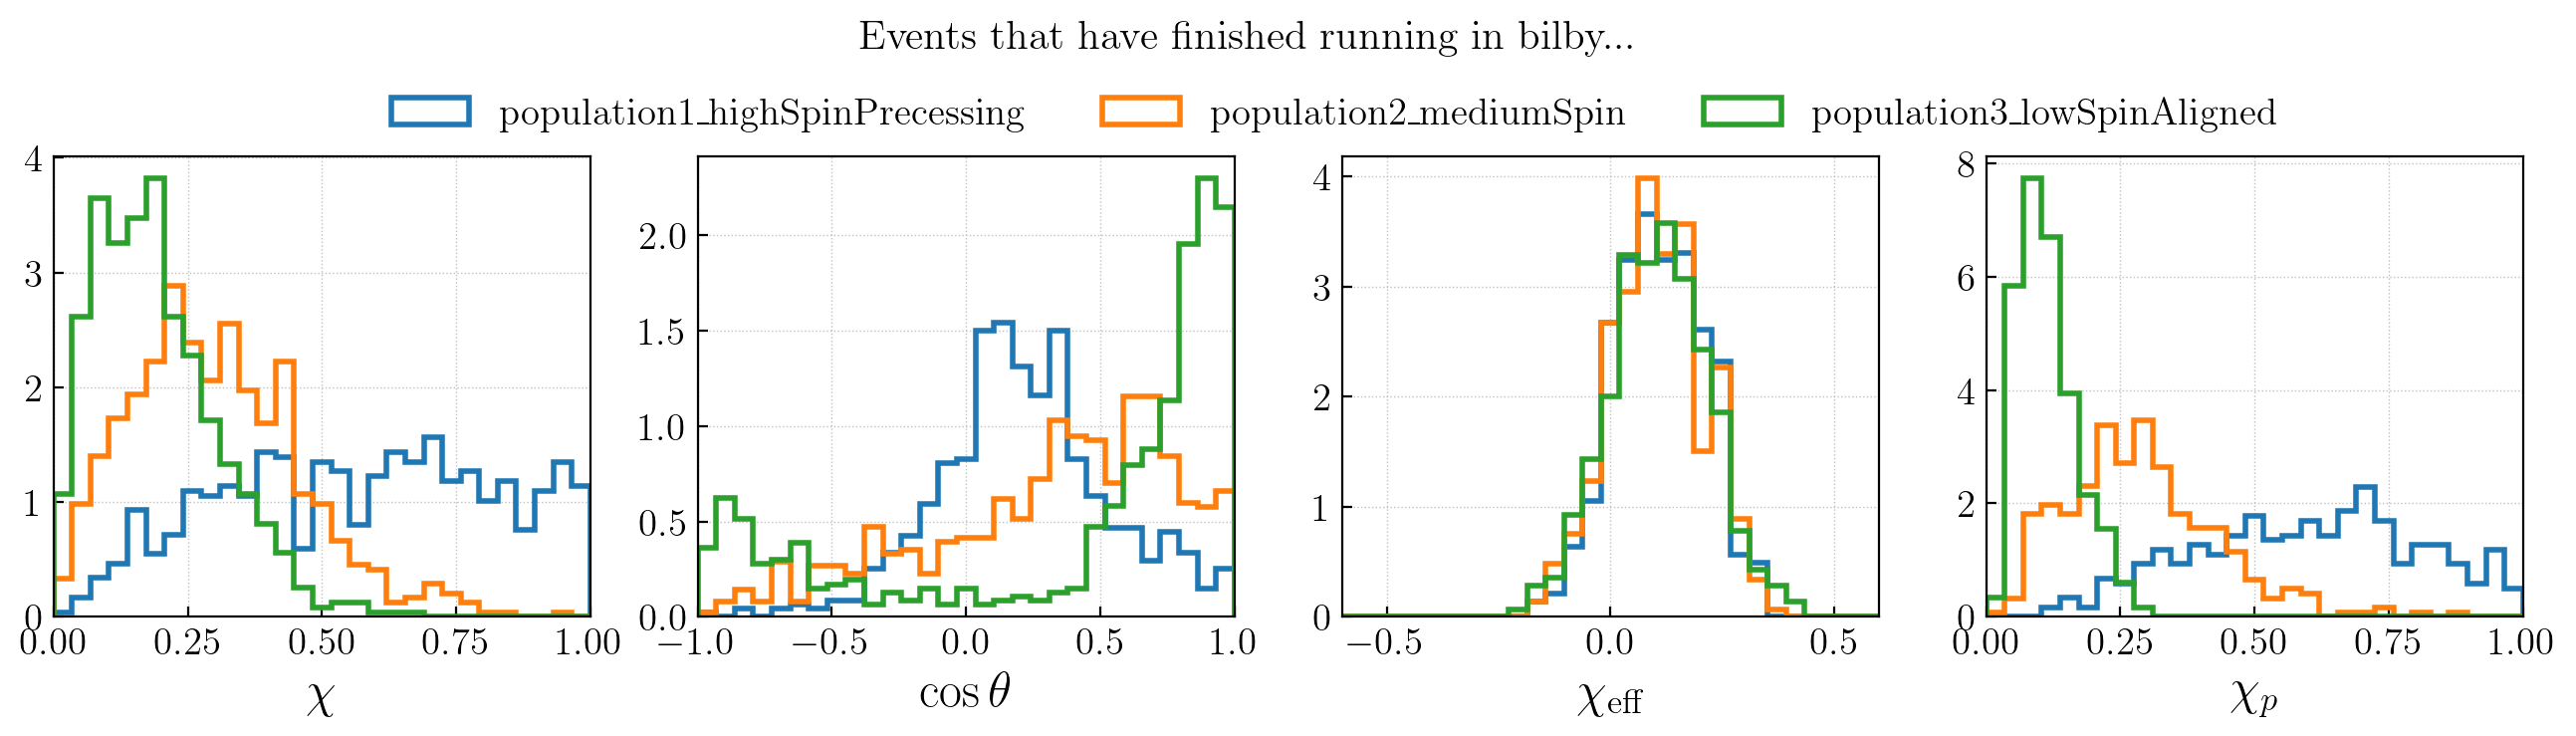

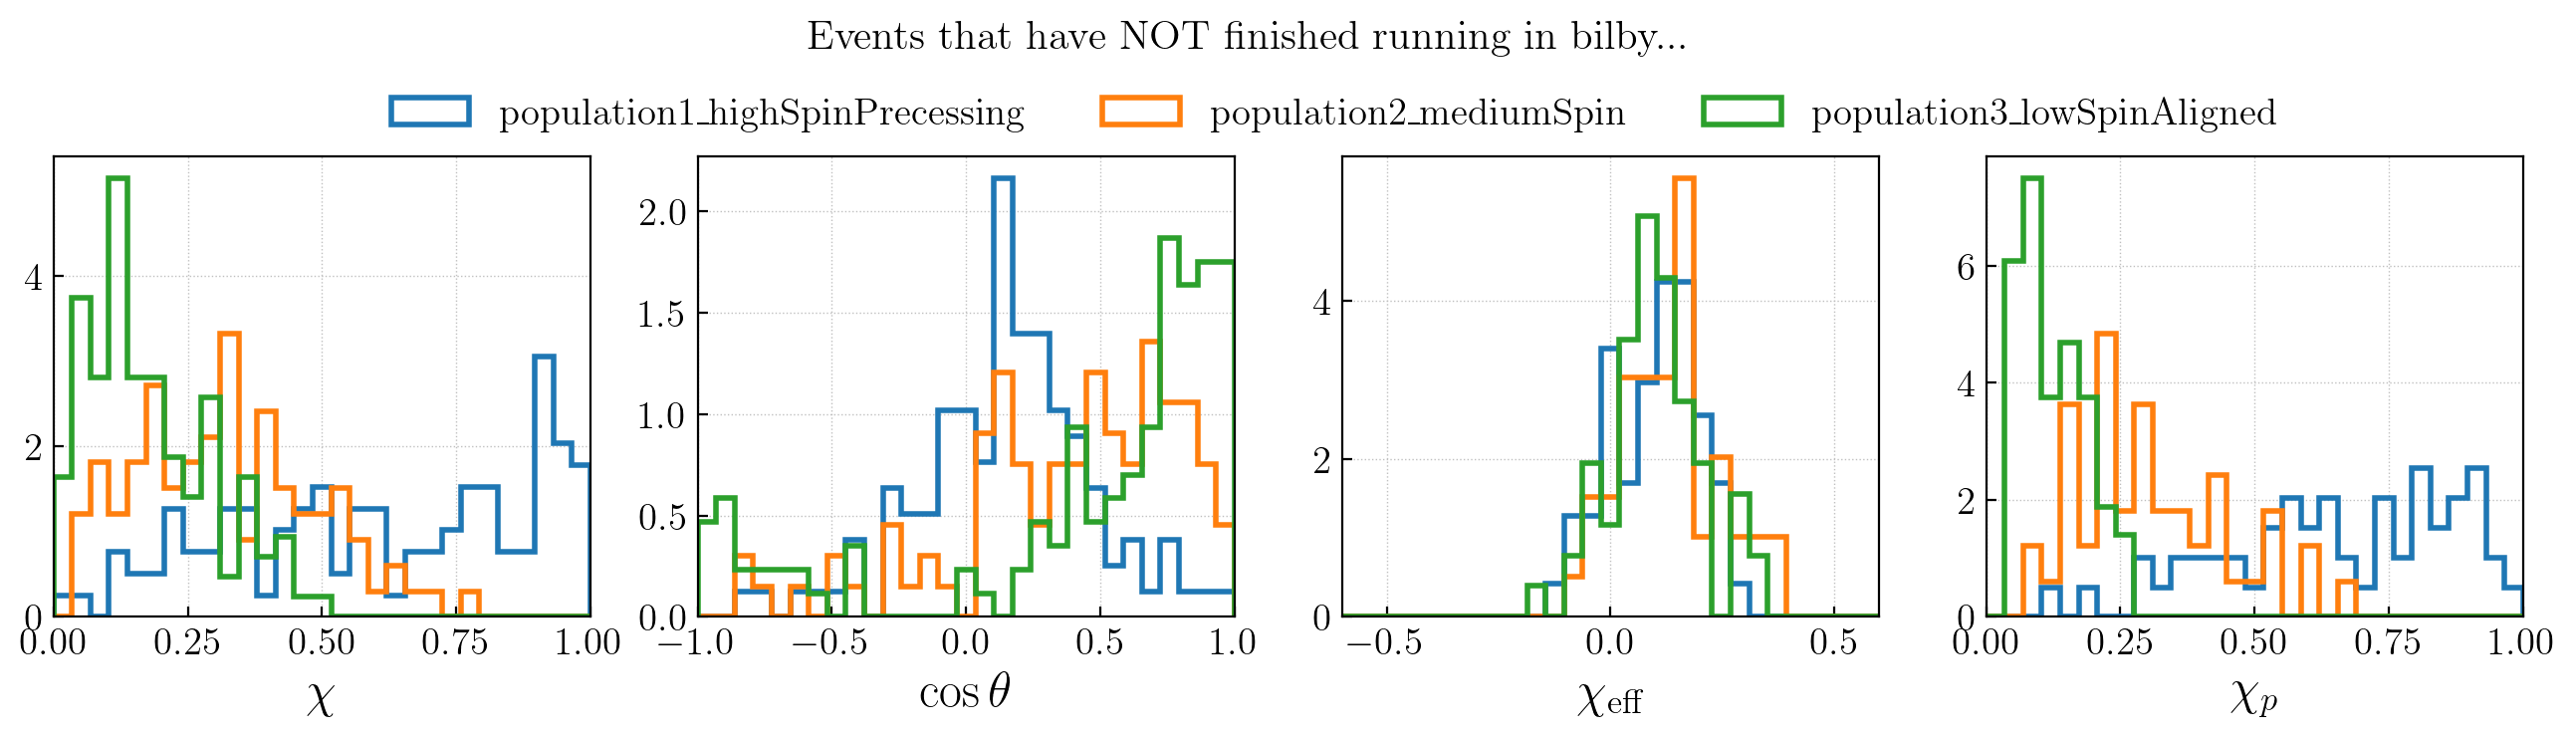

In [8]:
labels = [r'$\mathrm{\textsc{HighSpinPrecessing}}$', r'$\mathrm{\textsc{MediumSpin}}$', r'$\mathrm{\textsc{LowSpinAligned}}$']

nbins=30

for params_dict, ttl in zip([params_dict_finished, params_dict_missing], 
                              ['finished', 'NOT finished']):

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

    for pop in pop_names:

        # spin magnitude
        axes[0].hist(params_dict[pop]['chi'], density=True, bins=np.linspace(0, 1, nbins), histtype='step', lw=2, label=pop)
        axes[0].set_xlim(0,1)

        # tilt angle
        axes[1].hist(params_dict[pop]['cost'], density=True, bins=np.linspace(-1, 1, nbins), histtype='step', lw=2)
        axes[1].set_xlim(-1,1)

        # chi effective
        axes[2].hist(params_dict[pop]['chieff'], density=True, bins=np.linspace(-0.6, 0.6, nbins), histtype='step', lw=2)
        axes[2].set_xlim(-0.6,0.6)

        # chi p
        axes[3].hist(params_dict[pop]['chip'], density=True, bins=np.linspace(0, 1, nbins), histtype='step', lw=2)
        axes[3].set_xlim(0, 1)

    axes[0].legend(bbox_to_anchor=(0.6, 1.02, 1., .102), loc='lower left',
                          ncol=3,  borderaxespad=0.)

    axes[0].set_xlabel(r'$\chi$')
    axes[1].set_xlabel(r'$\cos\theta$')
    axes[2].set_xlabel(r'$\chi_\mathrm{eff}$')
    axes[3].set_xlabel(r'$\chi_p$')  

    for ax in axes: 
        ax.grid(ls=':', color='silver', lw=0.5)

    plt.suptitle(f'Events that have {ttl} running in bilby...', y=1.11, fontsize=15)

    plt.show()

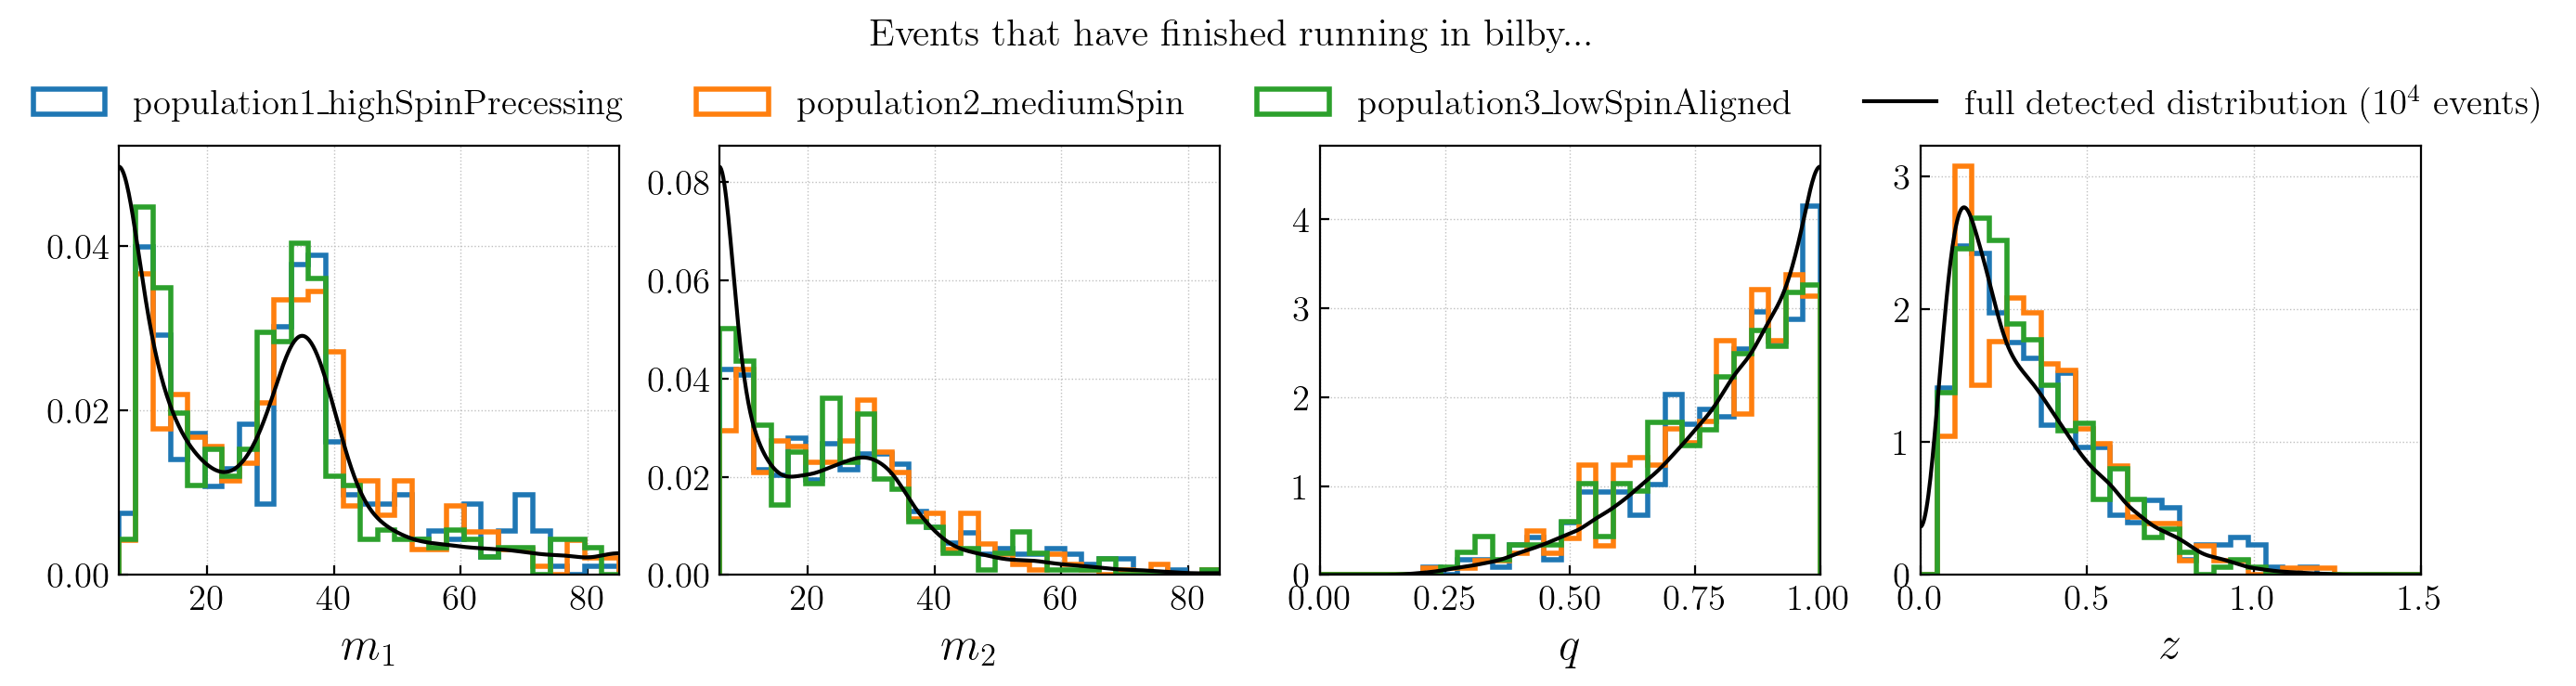

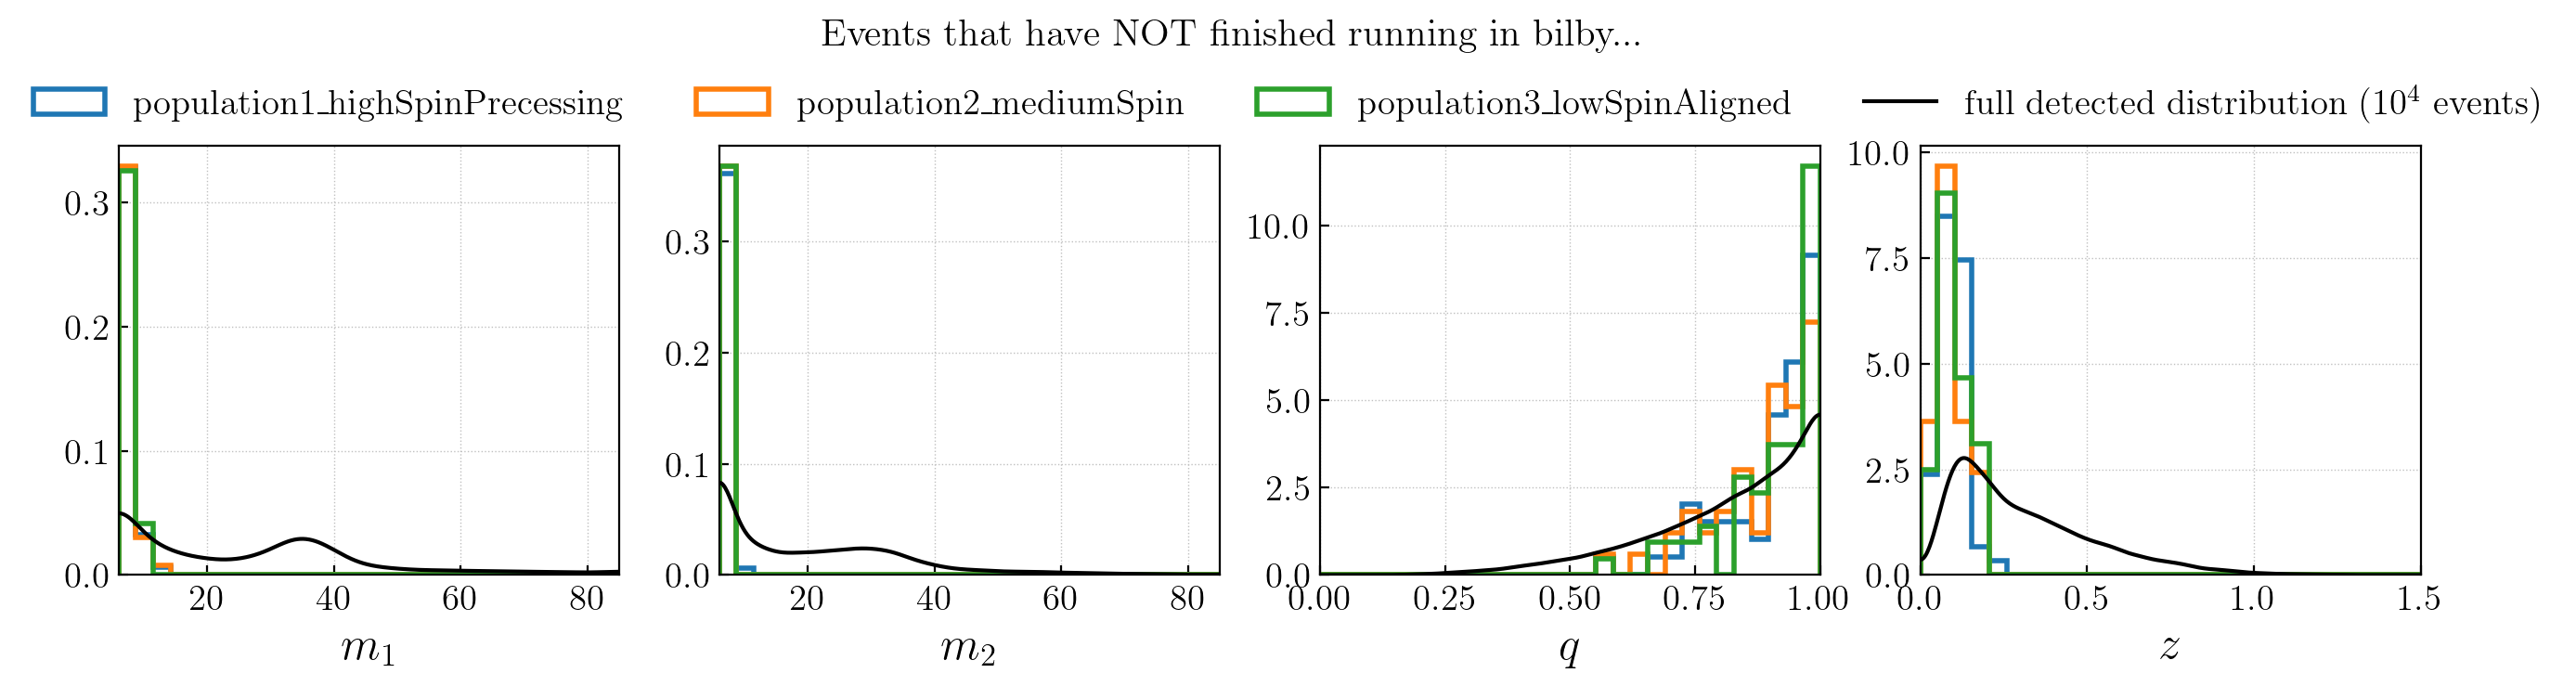

In [9]:
labels = [r'$\mathrm{\textsc{HighSpinPrecessing}}$', r'$\mathrm{\textsc{MediumSpin}}$', r'$\mathrm{\textsc{LowSpinAligned}}$']

for params_dict, ttl in zip([params_dict_finished, params_dict_missing], 
                              ['finished', 'NOT finished']):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

    for pop in pop_names:

        axes[0].hist(params_dict[pop]['m1'], density=True, bins=np.linspace(6, 85, nbins), histtype='step', lw=2, label=pop)

        axes[1].hist(params_dict[pop]['m2'], density=True, bins=np.linspace(6, 85, nbins), histtype='step', lw=2)

        axes[2].hist(params_dict[pop]['q'], density=True, bins=np.linspace(0, 1, nbins), histtype='step', lw=2)

        axes[3].hist(params_dict[pop]['z'], density=True, bins=np.linspace(0, 1.5, nbins), histtype='step', lw=2)


    axes[0].plot(m1_grid, kde_dict['m1'], color='k', label=r'full detected distribution ($10^4$ events)')
    axes[1].plot(m2_grid, kde_dict['m2'], color='k')
    axes[2].plot(q_grid, kde_dict['q'], color='k')
    axes[3].plot(z_grid, kde_dict['z'], color='k')

    axes[0].legend(bbox_to_anchor=(-0.2, 1.02, 1., .102), loc='lower left',
                          ncol=4,  borderaxespad=0.)

    axes[0].set_xlim(6,85)
    axes[1].set_xlim(6,85)
    axes[2].set_xlim(0,1)
    axes[3].set_xlim(0, 1.5)

    axes[0].set_xlabel(r'$m_1$')
    axes[1].set_xlabel(r'$m_2$')
    axes[2].set_xlabel(r'$q$')
    axes[3].set_xlabel(r'$z$')  

    plt.suptitle(f'Events that have {ttl} running in bilby...', y=1.11, fontsize=15)

    for ax in axes: 
        ax.grid(ls=':', color='silver', lw=0.5)

    plt.show()

In [26]:
# Print min chirp mass that has finished and max chirp mass that hasn't finished
for pop in pop_names:
    
    mc_finished = chirpmass(np.asarray(params_dict_finished[pop]['m1']), np.asarray(params_dict_finished[pop]['m2']))
    mc_notfinished = chirpmass(np.asarray(params_dict_missing[pop]['m1']), np.asarray(params_dict_missing[pop]['m2']))
    
    imin_finished = np.argmin(mc_finished)
    imax_notfinished = np.argmax(mc_notfinished)
    
    print(pop)
    print(f'minimum chirp mass that has finished is {mc_finished[imin_finished]} for ' 
           + f'job {int(joblists_finished[pop][imin_finished])}')
    print(f'maximum chirp mass that has not finished is {mc_notfinished[imax_notfinished]} for ' 
           + f'job {joblists_missing[pop][imax_notfinished]}')
    print()

population1_highSpinPrecessing
minimum chirp mass that has finished is 6.641320597959589 for job 7202
maximum chirp mass that has not finished is 9.408550834733006 for job 1799

population2_mediumSpin
minimum chirp mass that has finished is 6.128230781176791 for job 8567
maximum chirp mass that has not finished is 8.156760564187069 for job 8119

population3_lowSpinAligned
minimum chirp mass that has finished is 6.822313806746896 for job 768
maximum chirp mass that has not finished is 7.237883054528507 for job 3568



In [49]:
# Print min total mass that has finished and max total mass that hasn't finished
for pop in pop_names: 
    
    m1s = np.asarray(params_dict_finished[pop]['m1'])
    m2s = np.asarray(params_dict_finished[pop]['m2'])
    mtotals = m1s + m2s
    mchirp = chirpmass(m1s, m2s)
    
    cut = 30 
    
    print(pop)
    print(f'no. events with m1 > {cut}:', sum(m1s >= cut))
    print(f'no. events with m2 > {cut}:', sum(m2s >= cut))
    print(f'no. events with Mtotal > {cut}:', sum(mtotals >= cut))
    print(f'no. events with Mchirp > {cut}:', sum(mchirp >= cut))
    print()

population1_highSpinPrecessing
no. events with m1 > 30: 198
no. events with m2 > 30: 120
no. events with Mtotal > 30: 258
no. events with Mchirp > 30: 106

population2_mediumSpin
no. events with m1 > 30: 202
no. events with m2 > 30: 112
no. events with Mtotal > 30: 273
no. events with Mchirp > 30: 99

population3_lowSpinAligned
no. events with m1 > 30: 174
no. events with m2 > 30: 93
no. events with Mtotal > 30: 241
no. events with Mchirp > 30: 77



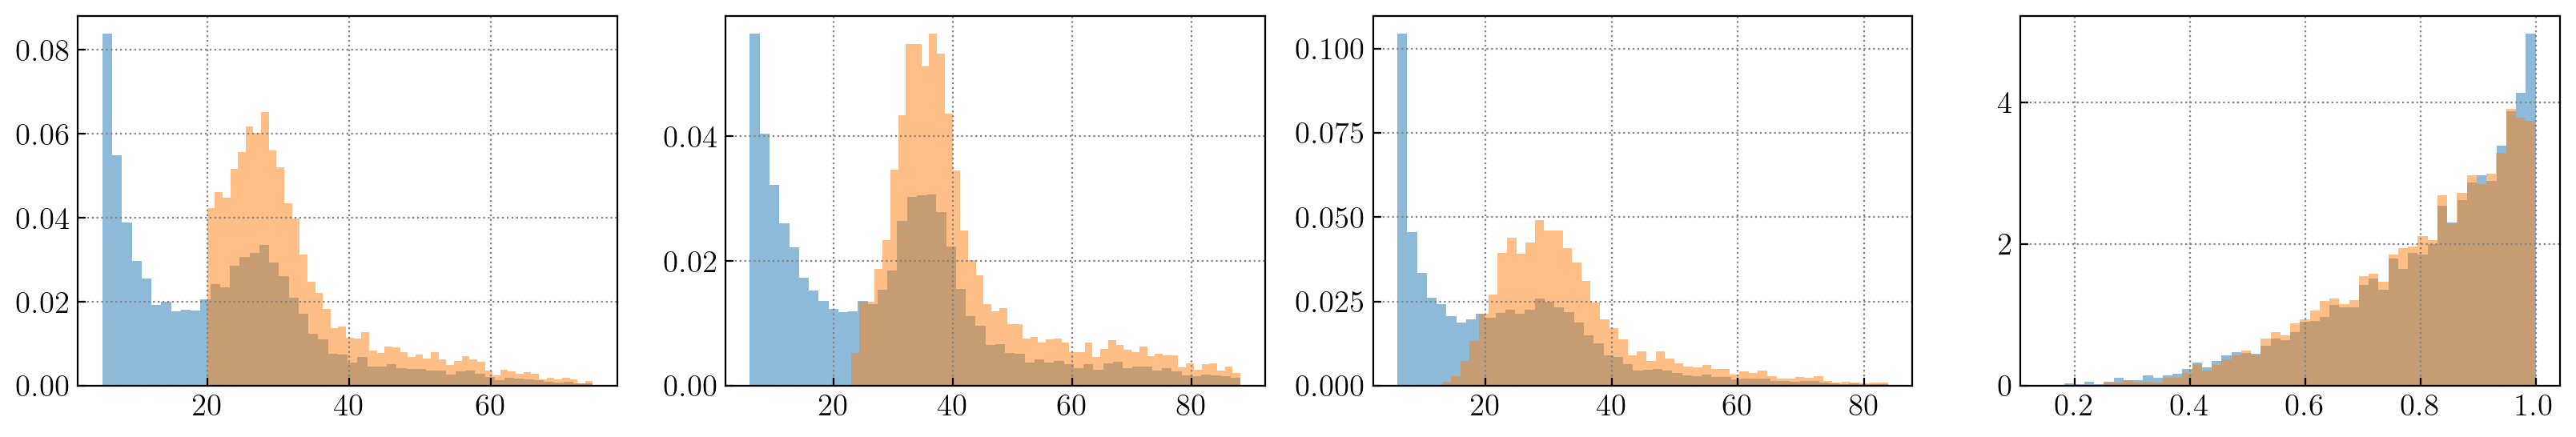

In [39]:
m1s = pop1.m1
m2s = pop1.m2
qs = m2s/m1s
mchirps_all = chirpmass(m1s, m2s)

mask = mchirps_all > 20

kws = dict(density=True, bins=50, alpha=0.5)

plt.figure(figsize=(20,3))

plt.subplot(141)
plt.hist(mchirps_all, **kws)
plt.hist(mchirps_all[mask], **kws)

plt.subplot(142)
plt.hist(m1s, **kws)
plt.hist(m1s[mask], **kws)

plt.subplot(143)
plt.hist(m2s, **kws)
plt.hist(m2s[mask], **kws)

plt.subplot(144)
plt.hist(qs, **kws)
plt.hist(qs[mask], **kws)

plt.show()

In [43]:
chirpmass(6,6)

5.223303379776745

### Plots cornerplots of individual event posteriors which have not yet been investigated

In [11]:
for pop in ['population1_highSpinPrecessing', 'population2_mediumSpin', 'population3_lowSpinAligned']:

    print(pop+'\n')

    for job in joblists_finished[pop]: 

        if job not in joblists_inspected[pop]:

            JOB=int(job) 
            print(JOB)

            try:
                # Read file
                f = '../{1}/job_{0:05d}_result.json'.format(JOB, pop)
                with open(f,'r') as jf:
                    result = json.load(jf)

                # Extract injected parameters
                inj_q = result['injection_parameters']['mass_ratio']
                inj_m1 = result['injection_parameters']['mass_1_source']
                inj_m2 = result['injection_parameters']['mass_2_source']
                inj_z = result['injection_parameters']['redshift']
                inj_chieff = result['injection_parameters']['chi_eff']
                inj_chip = result['injection_parameters']['chi_p']
                inj_chi1 = result['injection_parameters']['a_1']
                inj_chi2 = result['injection_parameters']['a_2']
                inj_costilt1 = result['injection_parameters']['cos_tilt_1']
                inj_costilt2 = result['injection_parameters']['cos_tilt_2']

                inj_Mc = chirpmass(inj_m1, inj_m2)

                # Injected snr
                inj_snr = get_snr(result['meta_data']['likelihood']['interferometers']['H1']['matched_filter_SNR'], 
                                  result['meta_data']['likelihood']['interferometers']['L1']['matched_filter_SNR'], 
                                  result['meta_data']['likelihood']['interferometers']['V1']['matched_filter_SNR'])

                inj_params = [inj_q,inj_Mc,inj_z,inj_chieff,inj_chip,inj_chi1,inj_chi2,inj_costilt1,inj_costilt2,inj_snr]

                print(inj_params)

                # Extract posterior samples
                m1 = np.array(result['posterior']['content']['mass_1_source'])
                m2 = np.array(result['posterior']['content']['mass_2_source'])
                z = np.array(result['posterior']['content']['redshift'])
                chiEff = np.array(result['posterior']['content']['chi_eff'])
                chiP = np.array(result['posterior']['content']['chi_p'])
                chi1 = np.array(result['posterior']['content']['a_1'])
                chi2 = np.array(result['posterior']['content']['a_2'])
                cost1 = np.array(result['posterior']['content']['cos_tilt_1'])
                cost2 = np.array(result['posterior']['content']['cos_tilt_2'])

                # Convert to mass ratio and chirp mass
                q = m2/m1
                Mc = chirpmass(m1, m2)

                # Calculate SNR 
                snr = np.asarray(
                    [get_snr(result['posterior']['content']['H1_matched_filter_snr'][i], 
                          result['posterior']['content']['L1_matched_filter_snr'][i], 
                          result['posterior']['content']['V1_matched_filter_snr'][i]) for i in range(len(result['posterior']['content']['L1_matched_filter_snr']))]
                )

                # Make a corner plot of the posterior samples
                labels = [r"$q$",r"$\mathcal{M}_c$",r'$z$',r'$\chi_\mathrm{eff}$',r'$\chi_\mathrm{p}$',
                          r"$\chi_1$",r"$\chi_2$",r"$\cos\theta_1$",r"$\cos\theta_2$", "snr"]
                ndim = len(labels)
                fig = corner(np.transpose([q,Mc,z,chiEff,chiP,chi1,chi2,cost1,cost2,snr]),labels=labels,fontsize=18)
                axes = np.array(fig.axes).reshape((ndim, ndim))

                # Overplot injected values as horizontal/vertical lines
                for i in range(ndim):
                    ax = axes[i, i]
                    ax.axvline(inj_params[i], color="black")
                for yi in range(ndim):
                    for xi in range(yi):
                        ax = axes[yi, xi]
                        ax.axvline(inj_params[xi], color="black")
                        ax.axhline(inj_params[yi], color="black")

                plt.suptitle(f'Job {JOB}', fontsize=18)
                plt.savefig('./cornerplots/{1}/{0:05d}.pdf'.format(JOB, pop))
                plt.show()

                print()

            except Exception as e:
                print(e)

    # Save the list of jobs we have already plotted             
    np.savetxt(f'{pop}_jobs_checked.txt',joblists_finished[pop],fmt="%d")

population1_highSpinPrecessing

population2_mediumSpin

population3_lowSpinAligned



## Determining which jobs to re-launch

**! RERUN THE FULL SCRIPT BEFORE DOING THIS !**

First, use confidence intervals to identify jobs that *have* finished but don't find the injection: 

In [12]:
def confidenceInterval(value, array_sorted): 
    
    min_idx = np.argmin(np.abs(array_sorted - value))
    
    if value < array_sorted[min_idx]:  
        n = min_idx 
    else: 
        n = min_idx + 1
        
    CI = n/len(array_sorted)
    
    return CI

In [13]:
# finished_jobs_to_redo = {}

# for pop in ['population1_highSpinPrecessing', 'population2_mediumSpin', 'population3_lowSpinAligned']:

#     print(pop)
    
#     jobs_to_redo = []

#     for job in joblists_inspected[pop]: 

#         JOB=int(job) 

#         # Read file
#         f = '../{1}/job_{0:05d}_result.json'.format(JOB, pop)
#         with open(f,'r') as jf:
#             result = json.load(jf)
               
#         # Extract injected parameters
#         inj_Mc = result['injection_parameters']['chirp_mass']
#         inj_q = result['injection_parameters']['mass_ratio']
#         inj_z = result['injection_parameters']['redshift']
       
#         # Extract posterior samples
#         Mc = np.sort(result['posterior']['content']['chirp_mass'])
#         q = np.sort(result['posterior']['content']['mass_ratio'])
#         z = np.sort(result['posterior']['content']['redshift'])
        
#         # Get confidence intervals 
#         Mc_CI = confidenceInterval(inj_Mc, Mc)
#         q_CI = confidenceInterval(inj_q, q)
#         z_CI = confidenceInterval(inj_z, z)
        
#         CIs = np.asarray([z_CI, Mc_CI, q_CI])
        
#         # Check which injected values fall outside 99% of posterior
#         if np.any(CIs[:-1] >= 0.995) or np.any(CIs <= 0.005):
#             jobs_to_redo+=[JOB] 
#             print(JOB, [Mc, q, z])
            
#     # Add to dict and print list
#     finished_jobs_to_redo[pop] = jobs_to_redo
#     print('')

Second, look at injected parameters of jobs that don't finish: 

In [14]:
# for i,pop in enumerate([pop1, pop2, pop3]):

#     for job in joblists_missing[pop_names[i]]:
        
#         JOB_ID = int(job)
        
#         # masses 
#         m1 = pop.m1[JOB_ID]
#         m2 = pop.m2[JOB_ID]
#         q = m2/m1
#         Mc = (q/(1.+q)**2)**(3./5.)*(m1+m2)
        
#         # redshift
#         z = pop.z[JOB_ID]
        
#         print(JOB_ID, [Mc, q, z])

Save list of events to relaunch

In [15]:
# to_relaunch_dict = {pop:np.concatenate([finished_jobs_to_redo[pop], joblists_missing[pop]]).tolist() for pop in pop_names}

# date = '071323'
# to_inject_dict_fname = f'../../../Code/IndividualInference/to_inject_dict_{date}.json'
# with open(to_inject_dict_fname, "w") as f:
#     json.dump(to_relaunch_dict, f)

Update random seeds of events that we need to relaunch in case this is the problem

In [16]:
# # Cycle through pops
# for pop_name, pop in zip(pop_names, [pop1, pop2, pop3]): 
    
#     print(pop_name)
    
#     pop_copied = pop.copy()
    
#     # Cycle through events
#     for event in to_relaunch_dict[pop_name]:
#         pop_copied.loc[event, 'seed'] = pop.loc[event, 'seed'] + 1
            
#     # Resave pop
#     pop_copied.to_json(f'../../../Data/InjectedPopulationParameters/{pop_name}_fullmassrange.json')

Or do it entirely manually

In [17]:
# Manual relaunches
# to_relaunch_manual = {
#     pop_names[0]:[190, 2675, 7504, 8363], 
#     pop_names[1]:[3668, 9249, 9933], 
#     pop_names[2]:[7445, 8639, 9265, 9828]
# }

# # Combine with auto relaunches
# to_relaunch_dict = {pop:np.concatenate([to_relaunch_manual[pop], joblists_missing[pop]]).tolist() for pop in pop_names}


# to_relaunch_manual = {
#     pop_names[0]:[], 
#     pop_names[1]:[2567, 4263], 
#     pop_names[2]:[1419]
# }

# to_relaunch_dict = to_relaunch_manual

# # Save
# date = '073123'
# to_inject_dict_fname = f'../../../Code/IndividualInference/to_inject_dict_{date}.json'
# with open(to_inject_dict_fname, "w") as f:
#     json.dump(to_relaunch_dict, f)

# # Update seeds 
# for pop_name, pop in zip(pop_names, [pop1, pop2, pop3]): 
    
#     print(pop_name)
    
#     pop_copied = pop.copy()
    
#     # Cycle through events
#     for event in to_relaunch_manual[pop_name]:
#         pop_copied.loc[event, 'seed'] = pop.loc[event, 'seed'] + 1
            
#     # Resave pop
#     pop_copied.to_json(f'../../../Data/InjectedPopulationParameters/{pop_name}_fullmassrange.json')